In [228]:
import os
import sys

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), "src"))
from mc_lab.metropolis_hastings import MetropolisHastingsSampler

# Configure ArviZ and matplotlib for publication-quality plots
az.style.use("arviz-darkgrid")

# Set publication-ready matplotlib style
plt.rcParams.update(
    {
        "figure.figsize": (12, 8),
        "font.size": 12,
        "font.family": "serif",
        "font.serif": [
            "Times New Roman",
            "DejaVu Serif",
            "serif",
        ],  # More universally available fonts
        "text.usetex": False,  # Set to True if LaTeX is available
        "axes.linewidth": 1.2,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.3,  # Fixed: removed 'axes.' prefix
        "grid.linewidth": 0.8,
        "lines.linewidth": 2.5,
        "lines.markersize": 8,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.major.size": 6,
        "ytick.major.size": 6,
        "xtick.minor.size": 4,
        "ytick.minor.size": 4,
        "legend.frameon": True,
        "legend.framealpha": 0.9,
        "legend.fancybox": True,
        "legend.shadow": True,
        "figure.dpi": 100,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.1,
    }
)

# Define consistent color palette for plots
COLORS = {
    "primary": "#2E86AB",  # Blue
    "secondary": "#A23B72",  # Purple
    "accent": "#F18F01",  # Orange
    "success": "#C73E1D",  # Red
    "dark": "#2F2F2F",  # Dark gray
    "light": "#CCCCCC",  # Light gray
    "true_density": "#C73E1D",  # Red for true density
    "histogram": "#2E86AB",  # Blue for histograms
    "trace": "#2F2F2F",  # Dark gray for traces
}

In [229]:
def plot_empirical_vs_theoretical(
    samples, target_func, ax, x_range=(-3, 3), bins=50, title=""
):
    """
    Clean helper function to plot empirical histogram vs theoretical density.
    Uses seaborn for better histogram aesthetics and systematic theoretical overlay.

    Parameters:
    -----------
    samples : array-like
        MCMC samples to plot as histogram
    target_func : callable
        Function that computes the unnormalized target density
    ax : matplotlib.axes.Axes
        Axes object to plot on
    x_range : tuple
        Range for theoretical curve evaluation
    bins : int or array-like
        Histogram bins
    title : str
        Plot title
    """
    # Use seaborn for cleaner histogram
    sns.histplot(
        data=samples,
        bins=bins,
        stat="density",
        alpha=0.7,
        color=COLORS["histogram"],
        edgecolor="white",
        linewidth=0.5,
        ax=ax,
        legend=False,
    )

    # High-resolution theoretical curve
    x_theory = np.linspace(x_range[0], x_range[1], 1000)
    y_theory = np.array([target_func(x) for x in x_theory])

    # Proper normalization using trapezoidal integration
    y_theory_normalized = y_theory / np.trapezoid(y_theory, x_theory)

    # Plot theoretical density
    ax.plot(
        x_theory,
        y_theory_normalized,
        color=COLORS["true_density"],
        linewidth=3,
        label="True density",
        linestyle="--",
    )

    # Styling
    ax.set_title(title, fontsize=14, fontweight="bold", pad=15)
    ax.set_ylabel("Density", fontsize=12, fontweight="bold")
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=10, loc="upper right")
    ax.grid(True, alpha=0.3)

In [230]:
def plot_trace(
    idata,
    ax,
    title="Trace Plot",
    max_samples=500,
    add_markers=False,
    marker_size=3,
    highlight_initial=None,
):
    """
    Reusable function to plot MCMC trace plots with consistent styling.

    Parameters:
    -----------
    idata : arviz.InferenceData
        ArviZ InferenceData object containing MCMC samples
    ax : matplotlib.axes.Axes
        Axes object to plot on
    title : str
        Plot title
    max_samples : int or None
        Maximum number of samples to plot (None for all samples)
    add_markers : bool
        Whether to add markers to the trace (useful for thinned samples)
    marker_size : int
        Size of markers if add_markers=True
    highlight_initial : float or None
        If provided, adds horizontal line at this initial value
    """
    # Extract samples from InferenceData
    samples_for_trace = idata.posterior.x.values[0]

    # Limit samples if requested
    if max_samples is not None:
        samples_for_trace = samples_for_trace[:max_samples]

    # Plot trace
    ax.plot(
        samples_for_trace,
        color=COLORS["trace"],
        linewidth=1.5,
        alpha=0.8,
        marker="o" if add_markers else None,
        markersize=marker_size if add_markers else 0,
    )

    # Add initial value highlight if requested
    if highlight_initial is not None:
        ax.axhline(
            y=highlight_initial,
            color=COLORS["accent"],
            linestyle=":",
            linewidth=2,
            alpha=0.7,
            label="Initial value",
        )
        ax.legend(fontsize=10)

    # Styling
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_ylabel("x", fontsize=12, fontweight="bold")
    ax.set_xlabel("Iteration", fontsize=12, fontweight="bold")
    ax.tick_params(labelsize=10)
    ax.grid(True, alpha=0.3)

In [231]:
rng = np.random.default_rng(2021)

In [232]:
def target(x):
    return np.exp(-(x**2)) * (2 + np.cos(7 * x) + np.sin(2 * x))

/var/folders/fy/zx0sb02j5rv66mcpx65ldmvc0000gn/T/ipykernel_15500/1115052749.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


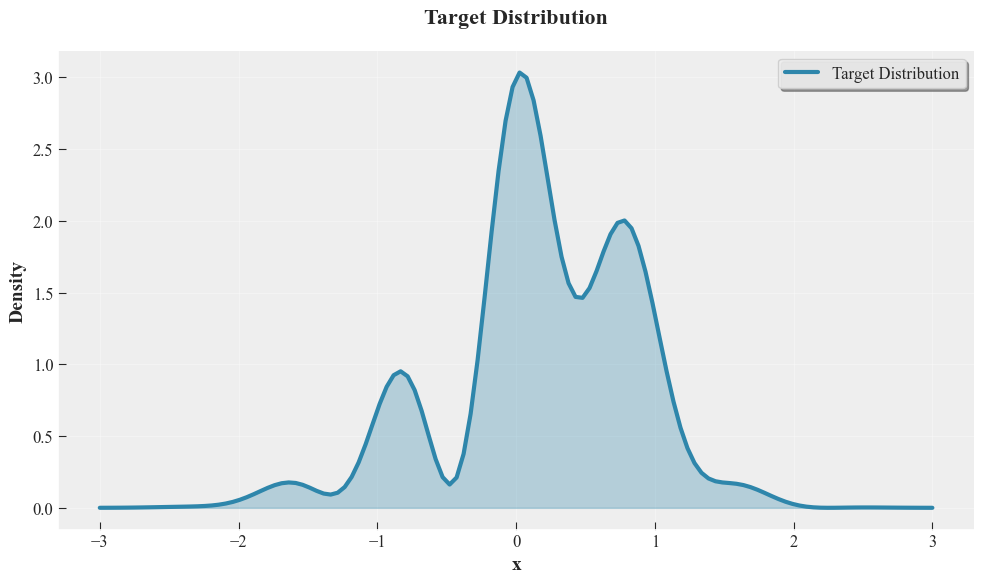

In [233]:
x = np.linspace(-3, 3, 120)
y = target(x)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y, color=COLORS["primary"], linewidth=3, label="Target Distribution")
ax.fill_between(x, y, alpha=0.3, color=COLORS["primary"])
ax.set_title("Target Distribution", fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel("x", fontsize=14, fontweight="bold")
ax.set_ylabel("Density", fontsize=14, fontweight="bold")
ax.tick_params(labelsize=12)
ax.legend(fontsize=12, loc="upper right")
plt.tight_layout()
plt.show()

In [234]:
def log_target(x):
    """Log probability of the target distribution."""
    x = np.atleast_1d(x)[0]  # Handle both scalar and array inputs
    return np.log(target(x)) if target(x) > 0 else -np.inf

In [235]:
def metropolis_sampler(initial_value, n=1000, sigma=1.0, burnin=0, lag=1):
    """Create sampler and return both samples and InferenceData for ArviZ plots."""
    sampler = MetropolisHastingsSampler(
        log_target=log_target,
        proposal_scale=sigma,
        adaptive_scaling=False,  # Disable adaptive scaling to match original behavior
    )

    # Sample using the class
    idata = sampler.sample(
        n_samples=n,
        n_chains=1,
        burn_in=burnin,
        thin=lag,
        initial_states=np.array([initial_value]),
        progressbar=False,
    )

    # Return both samples array (for compatibility) and idata (for ArviZ)
    return idata.posterior["x"].values[0], idata, sampler

In [236]:
result, idata_result, sampler_result = metropolis_sampler(
    initial_value=0, n=10000, lag=10
)

# Different sigmas

In [237]:
sigmas = [1, 0.025, 50]
n = 10000
traces = []

In [238]:
bins = np.linspace(-3, 3, 120)
p = target(bins)
expected = n * p / sum(p)

In [239]:
# Use updated function that returns ArviZ data
results_data = []
for i in range(len(sigmas)):
    samples, idata, sampler = metropolis_sampler(initial_value=-1, n=n, sigma=sigmas[i])
    traces.append(samples)
    results_data.append((idata, sampler))

/var/folders/fy/zx0sb02j5rv66mcpx65ldmvc0000gn/T/ipykernel_15500/2394130390.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


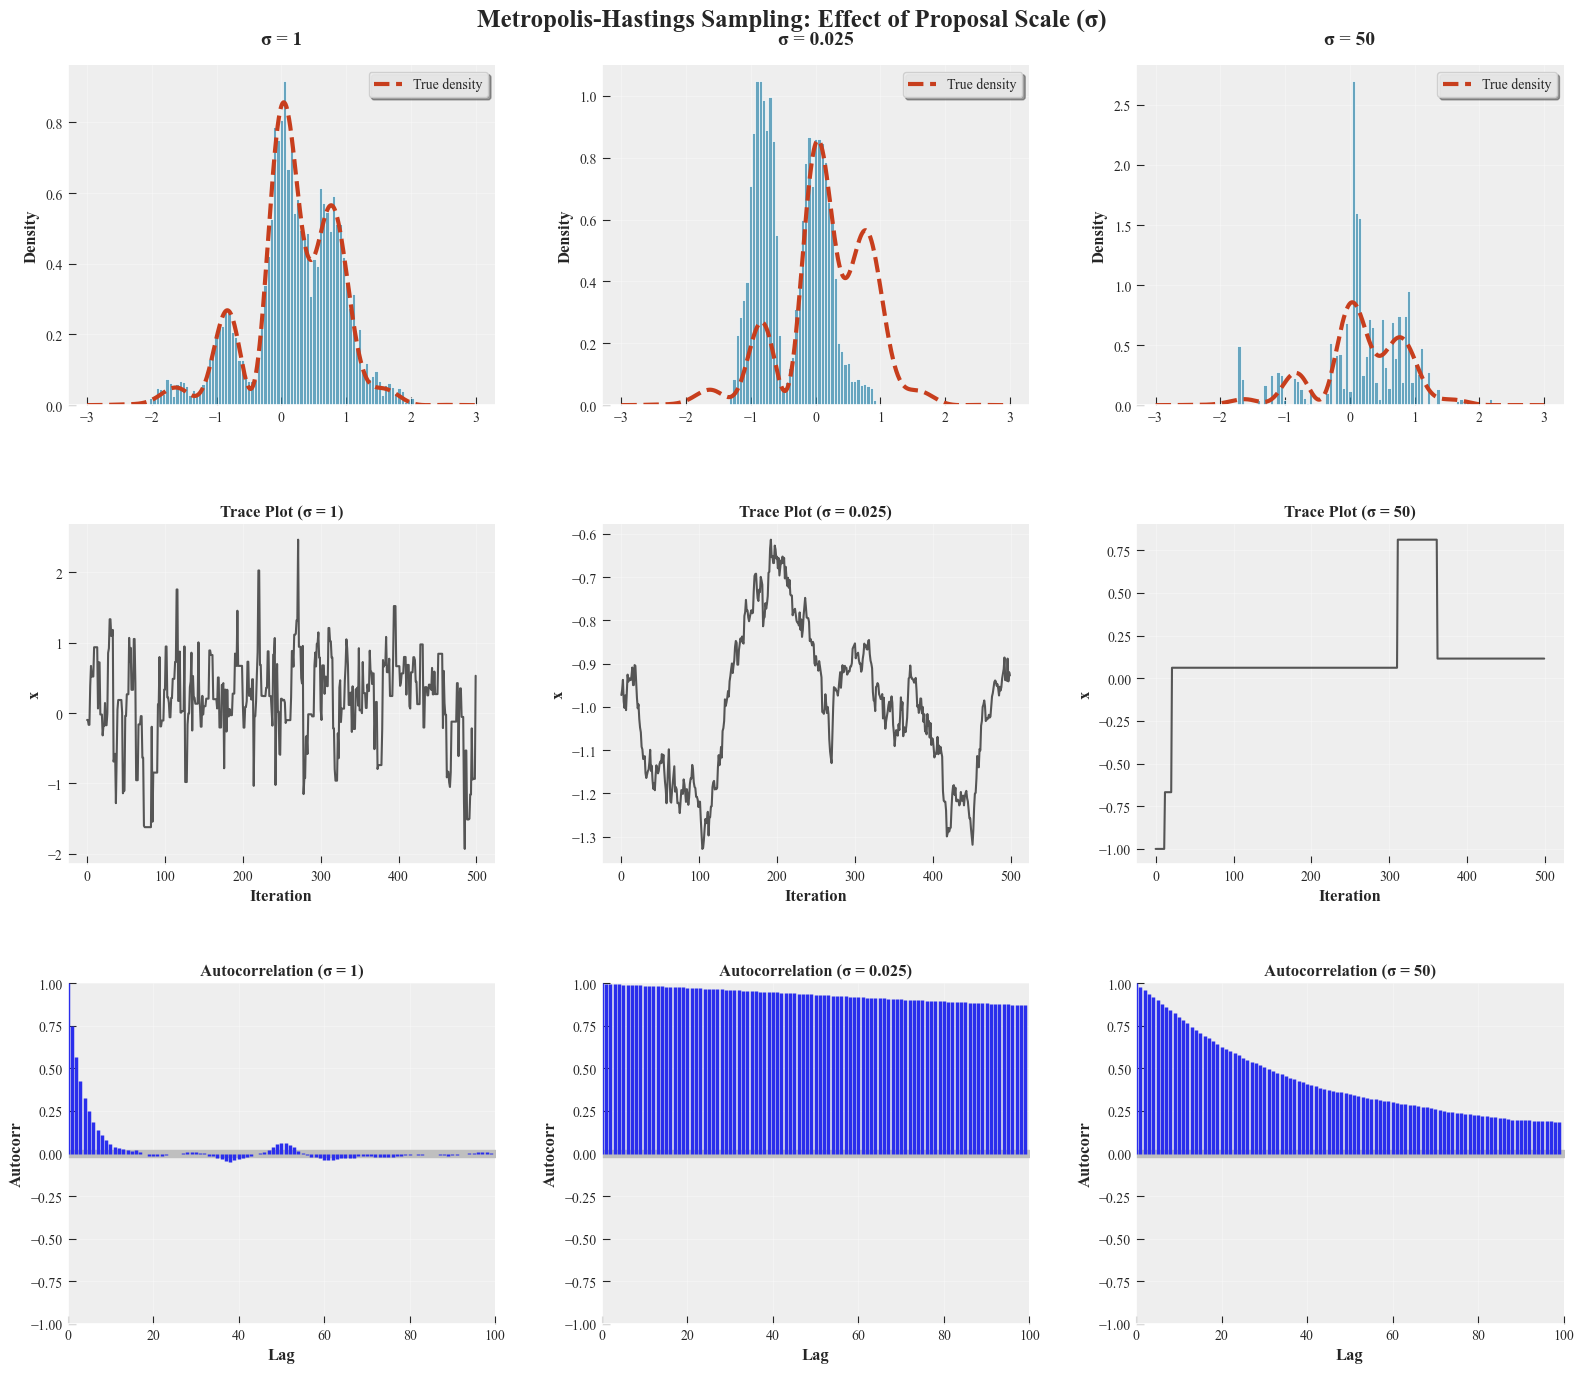

In [248]:
# Compare different sigma values using cleaner plotting approach
fig, axs = plt.subplots(3, 3, figsize=(16, 14))
fig.suptitle(
    "Metropolis-Hastings Sampling: Effect of Proposal Scale (σ)",
    fontsize=18,
    fontweight="bold",
    y=0.98,
)

for j in range(3):
    idata, sampler = results_data[j]
    sigma_val = sigmas[j]

    # Use the cleaner helper function for histogram + theoretical overlay
    plot_empirical_vs_theoretical(
        samples=traces[j],
        target_func=target,
        ax=axs[0, j],
        x_range=(-3, 3),
        bins=bins,
        title=f"σ = {sigma_val}",
    )

    # Use the reusable trace plot function
    plot_trace(
        idata=idata,
        ax=axs[1, j],
        title=f"Trace Plot (σ = {sigma_val})",
        max_samples=500,
    )

    # Use ArviZ autocorrelation plot with custom styling
    az.plot_autocorr(idata, var_names=["x"], ax=axs[2, j], combined=True, max_lag=100)
    axs[2, j].set_title(
        f"Autocorrelation (σ = {sigma_val})", fontsize=12, fontweight="bold"
    )
    axs[2, j].set_xlabel("Lag", fontsize=12, fontweight="bold")
    axs[2, j].set_ylabel("Autocorr", fontsize=12, fontweight="bold")
    axs[2, j].tick_params(labelsize=10)
    axs[2, j].grid(True, alpha=0.3)

    # Style the autocorr plot lines
    for line in axs[2, j].get_lines():
        line.set_color(COLORS["primary"])
        line.set_linewidth(2)

plt.tight_layout()
plt.subplots_adjust(top=0.94, hspace=0.35, wspace=0.25)
plt.show()

## No burn-in

In [241]:
# No burn-in example
results_data_no_burnin = []
traces_no_burnin = []
n = 1000
expected_small = n * p / sum(p)
for i in range(3):
    samples, idata, sampler = metropolis_sampler(initial_value=-3, n=n, sigma=0.1)
    traces_no_burnin.append(samples)
    results_data_no_burnin.append((idata, sampler))

/var/folders/fy/zx0sb02j5rv66mcpx65ldmvc0000gn/T/ipykernel_15500/3310775136.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


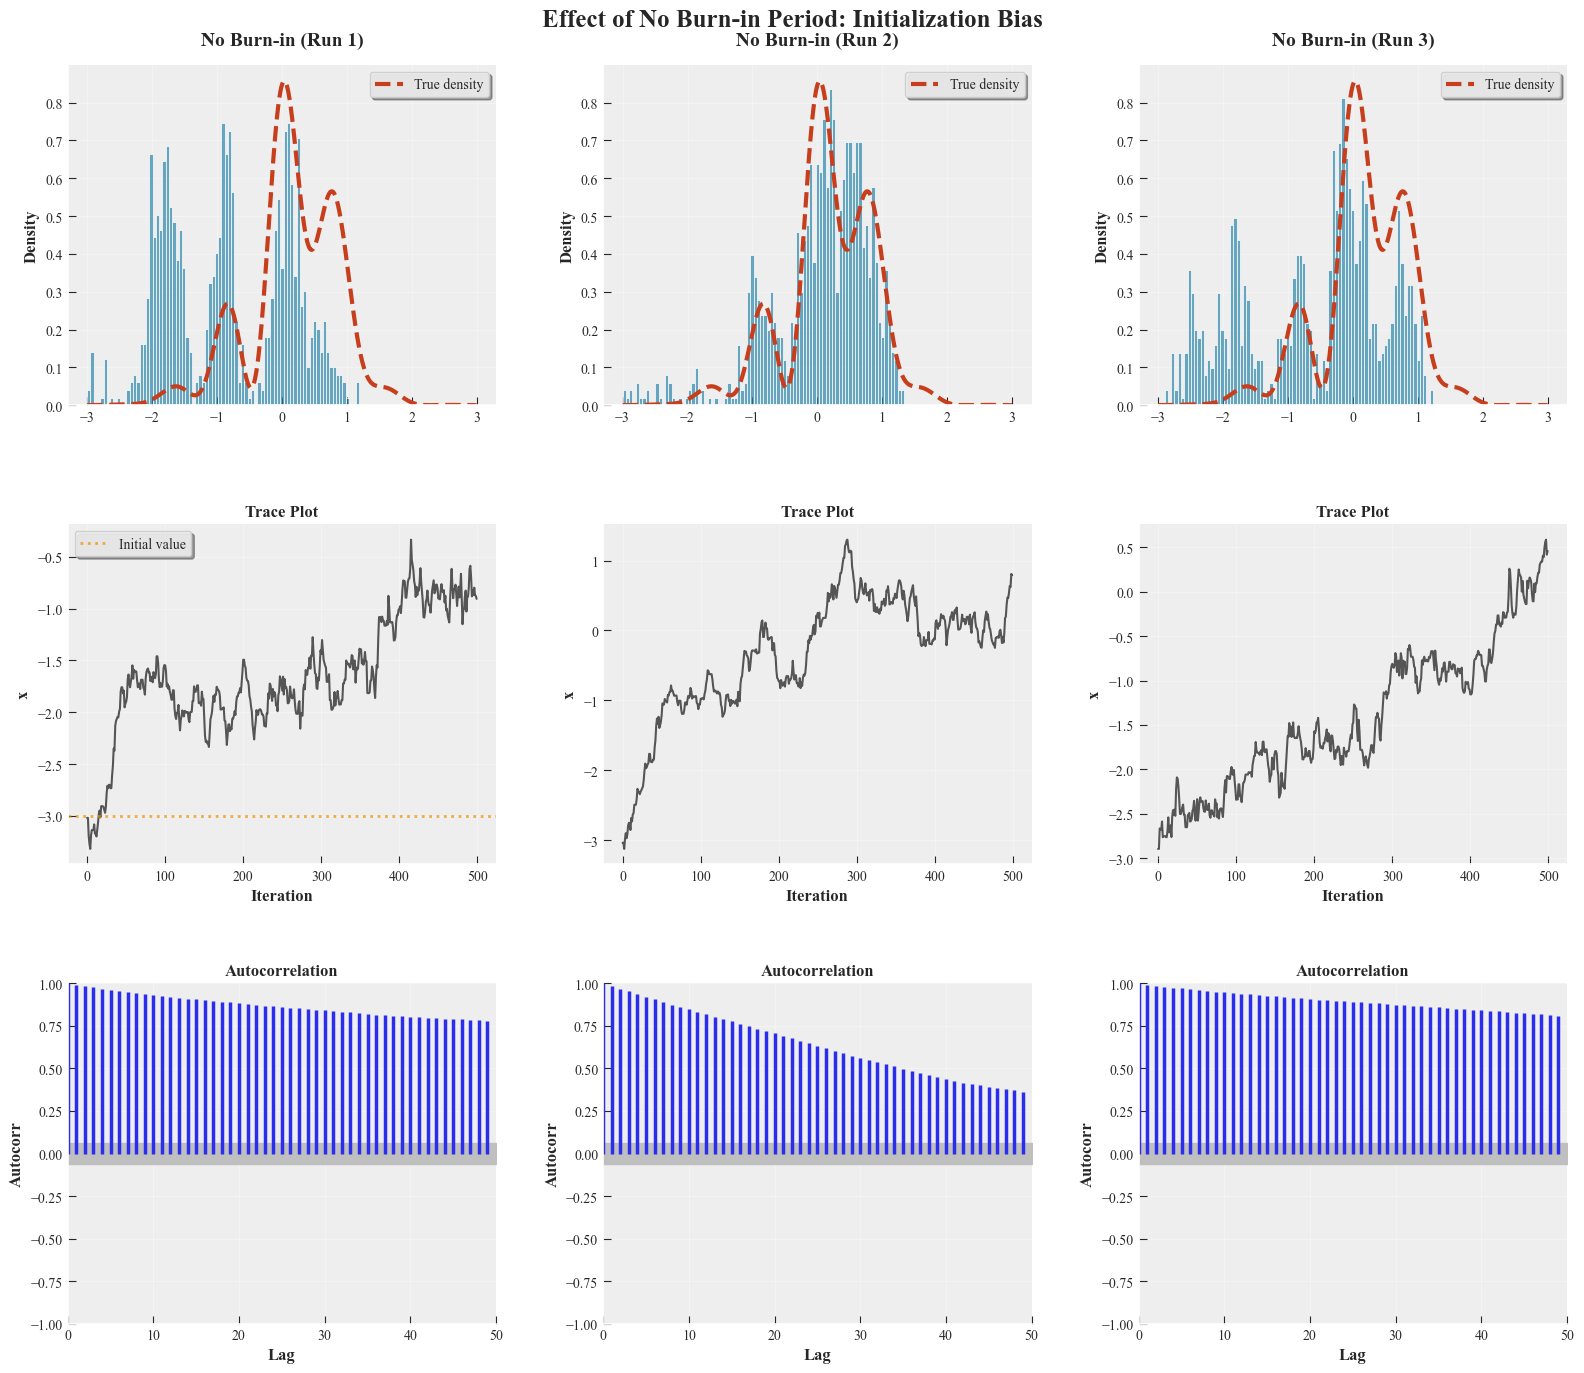

In [242]:
# No burn-in plots with ArviZ
fig, axs = plt.subplots(3, 3, figsize=(16, 14))
fig.suptitle(
    "Effect of No Burn-in Period: Initialization Bias",
    fontsize=18,
    fontweight="bold",
    y=0.98,
)

for j in range(3):
    idata, sampler = results_data_no_burnin[j]

    # Use the cleaner helper function for histogram + theoretical overlay
    plot_empirical_vs_theoretical(
        samples=traces_no_burnin[j],
        target_func=target,
        ax=axs[0, j],
        x_range=(-3, 3),
        bins=bins,
        title=f"No Burn-in (Run {j + 1})",
    )
    # Change y-axis label to "Density" to match the helper function
    axs[0, j].set_ylabel("Density", fontsize=12, fontweight="bold")

    # Use the reusable trace plot function with initial value highlight
    plot_trace(
        idata=idata,
        ax=axs[1, j],
        title="Trace Plot",
        highlight_initial=-3 if j == 0 else None,  # Only highlight for first plot
    )

    # ArviZ autocorrelation
    az.plot_autocorr(idata, var_names=["x"], ax=axs[2, j], combined=True, max_lag=50)
    axs[2, j].set_title("Autocorrelation", fontsize=12, fontweight="bold")
    axs[2, j].set_xlabel("Lag", fontsize=12, fontweight="bold")
    axs[2, j].set_ylabel("Autocorr", fontsize=12, fontweight="bold")
    axs[2, j].tick_params(labelsize=10)
    axs[2, j].grid(True, alpha=0.3)

    # Style the autocorr plot lines
    for line in axs[2, j].get_lines():
        line.set_color(COLORS["primary"])
        line.set_linewidth(2)

plt.tight_layout()
plt.subplots_adjust(top=0.94, hspace=0.35, wspace=0.25)
plt.show()

## Burn-in - but no thinning and poorly chosen sigma

In [243]:
# With burn-in example
results_data_burnin = []
traces_burnin = []
n = 1000
expected_small = n * p / sum(p)
for i in range(3):
    samples, idata, sampler = metropolis_sampler(
        initial_value=-3, burnin=200, n=n, sigma=0.1
    )
    traces_burnin.append(samples)
    results_data_burnin.append((idata, sampler))

/var/folders/fy/zx0sb02j5rv66mcpx65ldmvc0000gn/T/ipykernel_15500/1091645081.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


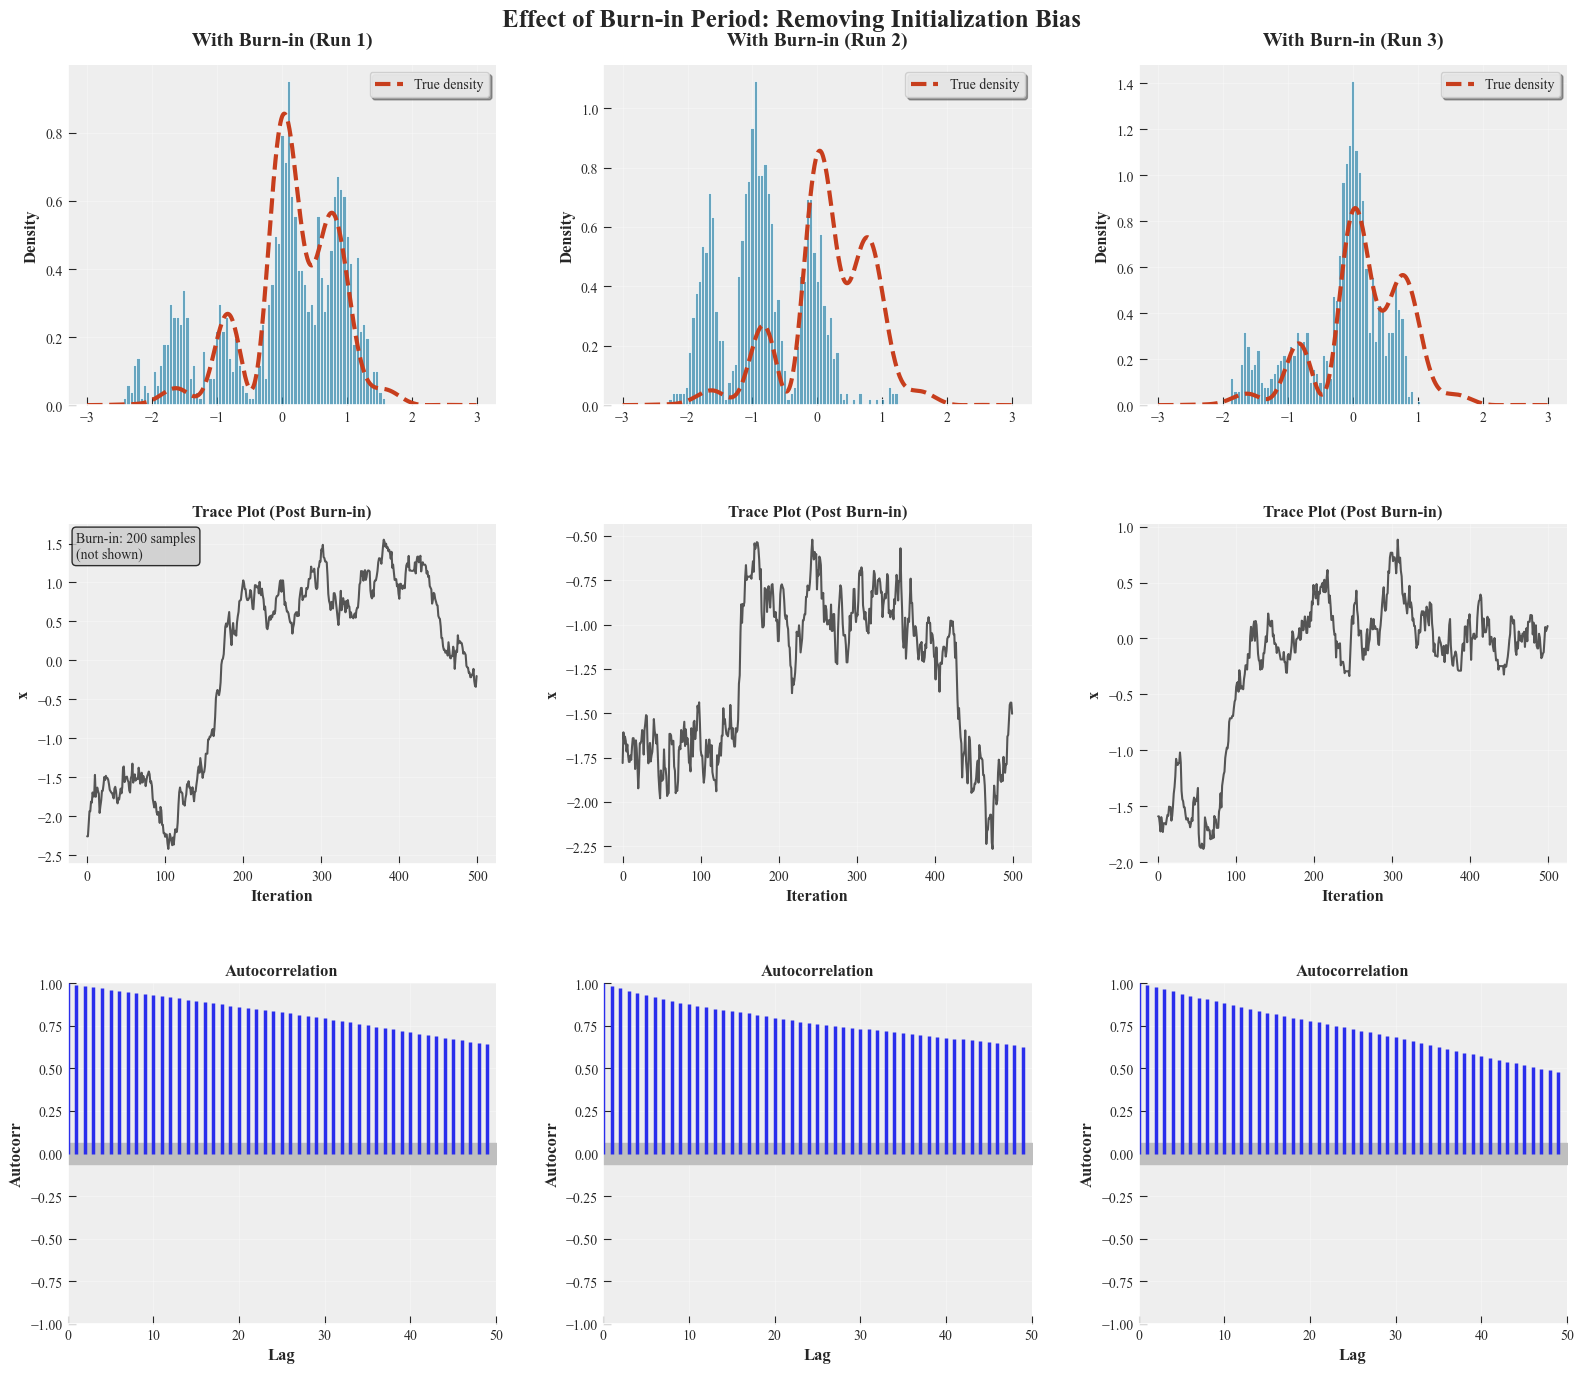

In [244]:
# Burn-in plots with ArviZ
fig, axs = plt.subplots(3, 3, figsize=(16, 14))
fig.suptitle(
    "Effect of Burn-in Period: Removing Initialization Bias",
    fontsize=18,
    fontweight="bold",
    y=0.98,
)

for j in range(3):
    idata, sampler = results_data_burnin[j]

    # Use the cleaner helper function for histogram + theoretical overlay
    plot_empirical_vs_theoretical(
        samples=traces_burnin[j],
        target_func=target,
        ax=axs[0, j],
        x_range=(-3, 3),
        bins=bins,
        title=f"With Burn-in (Run {j + 1})",
    )
    # Change y-axis label to "Density" to match the helper function
    axs[0, j].set_ylabel("Density", fontsize=12, fontweight="bold")

    # Use the reusable trace plot function
    plot_trace(idata=idata, ax=axs[1, j], title="Trace Plot (Post Burn-in)")

    # Add annotation for burn-in period for first plot only
    if j == 0:
        axs[1, j].text(
            0.02,
            0.98,
            "Burn-in: 200 samples\n(not shown)",
            transform=axs[1, j].transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor=COLORS["light"], alpha=0.8),
        )

    # ArviZ autocorrelation
    az.plot_autocorr(idata, var_names=["x"], ax=axs[2, j], combined=True, max_lag=50)
    axs[2, j].set_title("Autocorrelation", fontsize=12, fontweight="bold")
    axs[2, j].set_xlabel("Lag", fontsize=12, fontweight="bold")
    axs[2, j].set_ylabel("Autocorr", fontsize=12, fontweight="bold")
    axs[2, j].tick_params(labelsize=10)
    axs[2, j].grid(True, alpha=0.3)

    # Style the autocorr plot lines
    for line in axs[2, j].get_lines():
        line.set_color(COLORS["primary"])
        line.set_linewidth(2)

plt.tight_layout()
plt.subplots_adjust(top=0.94, hspace=0.35, wspace=0.25)
plt.show()

## Thinning / lag

In [245]:
# Thinning/lag example
results_data_lag = []
traces_lag = []
n = 1000
expected_small = n * p / sum(p)
lag = [1, 10, 100]
for i in range(3):
    samples, idata, sampler = metropolis_sampler(
        initial_value=0, burnin=200, lag=lag[i], n=n, sigma=50
    )
    traces_lag.append(samples)
    results_data_lag.append((idata, sampler))

/var/folders/fy/zx0sb02j5rv66mcpx65ldmvc0000gn/T/ipykernel_15500/2911288435.py:62: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


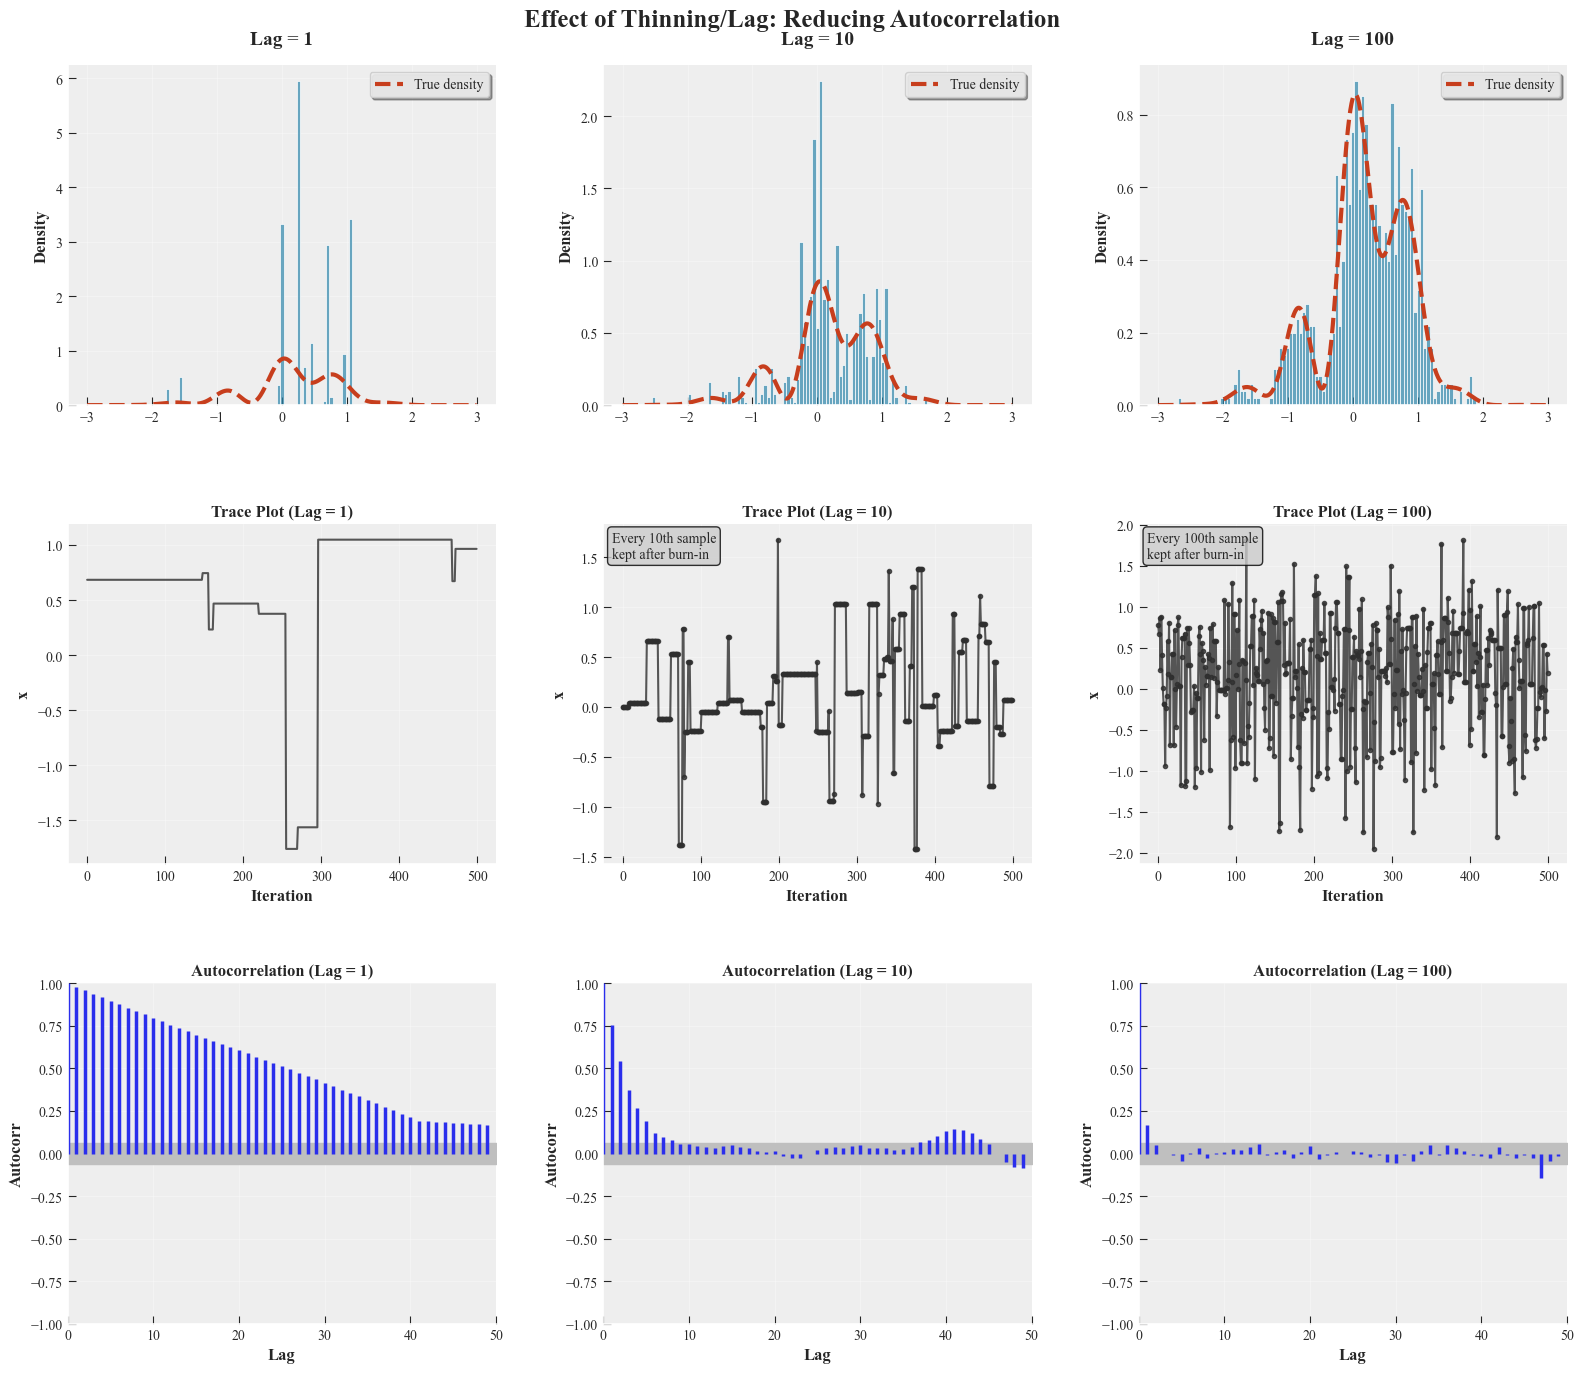

In [246]:
# Thinning/lag plots with ArviZ
fig, axs = plt.subplots(3, 3, figsize=(16, 14))
fig.suptitle(
    "Effect of Thinning/Lag: Reducing Autocorrelation",
    fontsize=18,
    fontweight="bold",
    y=0.98,
)

for j in range(3):
    idata, sampler = results_data_lag[j]
    lag_val = lag[j]

    # Use the cleaner helper function for histogram + theoretical overlay
    plot_empirical_vs_theoretical(
        samples=traces_lag[j],
        target_func=target,
        ax=axs[0, j],
        x_range=(-3, 3),
        bins=bins,
        title=f"Lag = {lag_val}",
    )
    # Change y-axis label to "Density" to match the helper function
    axs[0, j].set_ylabel("Density", fontsize=12, fontweight="bold")

    # Use the reusable trace plot function with markers for thinned samples
    plot_trace(
        idata=idata,
        ax=axs[1, j],
        title=f"Trace Plot (Lag = {lag_val})",
        add_markers=lag_val > 1,  # Add markers for thinned samples
        marker_size=3,
    )

    # Add annotation about thinning
    if lag_val > 1:
        axs[1, j].text(
            0.02,
            0.98,
            f"Every {lag_val}th sample\nkept after burn-in",
            transform=axs[1, j].transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor=COLORS["light"], alpha=0.8),
        )

    # ArviZ autocorrelation
    az.plot_autocorr(idata, var_names=["x"], ax=axs[2, j], combined=True, max_lag=50)
    axs[2, j].set_title(
        f"Autocorrelation (Lag = {lag_val})", fontsize=12, fontweight="bold"
    )
    axs[2, j].set_xlabel("Lag", fontsize=12, fontweight="bold")
    axs[2, j].set_ylabel("Autocorr", fontsize=12, fontweight="bold")
    axs[2, j].tick_params(labelsize=10)
    axs[2, j].grid(True, alpha=0.3)

    # Style the autocorr plot lines
    for line in axs[2, j].get_lines():
        line.set_color(COLORS["primary"])
        line.set_linewidth(2)

plt.tight_layout()
plt.subplots_adjust(top=0.94, hspace=0.35, wspace=0.25)
plt.show()

## Summary

This notebook demonstrates the same educational comparisons as the original:

1. **Different sigma values** - showing the trade-off between acceptance rate and mixing
2. **No burn-in** - showing the effect of initialization bias
3. **With burn-in** - showing how burn-in removes initialization effects
4. **Different lag/thinning** - showing how thinning reduces autocorrelation
